# Land Use Classification using TensorFlow from scratch
In this notebook, we illustrate how one can produce a deep learning model to classify aerial images based on land use type (developed, forested, cultivated, etc.). We apply transfer learning with MicrosoftML to adapt a pretrained featurizer for our classification use case.

<a name="prep"></a>
## Prepare deep learning framework-specific input files

If you have not generated your own training and validation sets through image extraction, download the following files and decompress them in your VM's temporary (`D:\`) storage:
- [Balanced training image set (~3 GB)](https://mawahstorage.blob.core.windows.net/aerialimageclassification/imagesets/balanced_training_set.zip)
- [Balanced validation image set (~1 GB)](https://mawahstorage.blob.core.windows.net/aerialimageclassification/imagesets/balanced_validation_set.zip)

The image sets linked above contain raw PNG images sorted into folders by their assigned label. 

Update the `training_image_dir` variable below to reflect the directory where your training and validation sets have been saved. The `label_to_number_dict` variable specifies the correspondence between the label names and a numeric code; it does not need to be modified unless you have changed the labeling scheme.

In [15]:
# Imports
import os, sys
import numpy as np
import tensorflow as tf
import pandas as pd
from sklearn.metrics import confusion_matrix, accuracy_score

from tensorflow.contrib import learn
from tensorflow.contrib.learn.python.learn.estimators import model_fn

import land_use.connection_settings as cs
import land_use.land_use_classification_utils as luc

image_dir = cs.IMAGE_DIR
tf_model_dir = os.path.join(cs.IMAGE_DIR, "TFTrainCheckpoints")
connection_string = cs.get_connection_string()
label_to_number_dict = cs.LABELS

tf.logging.set_verbosity(tf.logging.INFO)

# Autoreload when modules are changed
%load_ext autoreload
%autoreload 2

# Show matplotlib plots inline
%matplotlib inline

DRIVER={ODBC Driver 13 for SQL Server};SERVER=TYLER-LAPTOP\TYLERSQLSERVER;PORT=21816;DATABASE=land_use_database;Trusted_Connection=Yes
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Load Training Data

In [2]:
if 'train_data' in locals():
    print("Freeing up memory...")
    del train_data
    
if 'eval_data' in locals():
    print("Freeing up memory...")
    del eval_data
    
if 'test_data' in locals():
    print("Freeing up memory...")
    del test_data
    
print("Load training data")
train_info = luc.gather_image_paths(image_dir, label_to_number_dict, connection_string, mode="train")
train_data, train_labels = luc.load_data(train_info)

print(train_data.shape)
print(train_labels.shape)

Load training data
Rows Read: 44184, Total Rows Processed: 44184, Total Chunk Time: 27.932 seconds 
\\Tyler-laptop\tylersqlserver\FileTableData\TrainData\Shrub\ortho_1-1_hn_s_ca025_2016_1_100087.png
[2 2 2 ..., 4 4 4]
(44184, 224, 224, 3)
(44184, 224, 224, 3)
(44184,)


## Train the Image Classifier

In [3]:
# Create the Estimator
classifier = learn.SKCompat(learn.Estimator(model_fn=luc.cnn_model_fn, model_dir=tf_model_dir, config=learn.RunConfig(keep_checkpoint_max=1)))

INFO:tensorflow:Using config: {'_save_checkpoints_secs': 600, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x000002464B68A2E8>, '_tf_config': gpu_options {
  per_process_gpu_memory_fraction: 1
}
, '_num_ps_replicas': 0, '_evaluation_master': '', '_keep_checkpoint_max': 1, '_master': '', '_tf_random_seed': None, '_save_checkpoints_steps': None, '_environment': 'local', '_num_worker_replicas': 0, '_model_dir': '\\\\Tyler-laptop\\tylersqlserver\\FileTableData\\TFTrainCheckpoints', '_save_summary_steps': 100, '_is_chief': True, '_task_type': None, '_keep_checkpoint_every_n_hours': 10000, '_session_config': None, '_task_id': 0}


INFO:tensorflow:Using config: {'_save_checkpoints_secs': 600, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x000002464B68A2E8>, '_tf_config': gpu_options {
  per_process_gpu_memory_fraction: 1
}
, '_num_ps_replicas': 0, '_evaluation_master': '', '_keep_checkpoint_max': 1, '_master': '', '_tf_random_seed': None, '_save_checkpoints_steps': None, '_environment': 'local', '_num_worker_replicas': 0, '_model_dir': '\\\\Tyler-laptop\\tylersqlserver\\FileTableData\\TFTrainCheckpoints', '_save_summary_steps': 100, '_is_chief': True, '_task_type': None, '_keep_checkpoint_every_n_hours': 10000, '_session_config': None, '_task_id': 0}


In [4]:
# Train the model
classifier.fit(
    x=train_data,
    y=train_labels,
    batch_size=100,
    steps=5000
)

                                               image  class  label
0  \\Tyler-laptop\tylersqlserver\FileTableData\Tr...  Shrub      2
1  \\Tyler-laptop\tylersqlserver\FileTableData\Tr...  Shrub      2
2  \\Tyler-laptop\tylersqlserver\FileTableData\Tr...  Shrub      2
3  \\Tyler-laptop\tylersqlserver\FileTableData\Tr...  Shrub      2
4  \\Tyler-laptop\tylersqlserver\FileTableData\Tr...  Shrub      2
[2 2 2 ..., 4 4 4]
Tensor("output:0", shape=(?,), dtype=int64)
INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Saving checkpoints for 1 into \\Tyler-laptop\tylersqlserver\FileTableData\TFTrainCheckpoints\model.ckpt.


INFO:tensorflow:Saving checkpoints for 1 into \\Tyler-laptop\tylersqlserver\FileTableData\TFTrainCheckpoints\model.ckpt.


INFO:tensorflow:loss = 69.8813, step = 1


INFO:tensorflow:loss = 69.8813, step = 1


INFO:tensorflow:Saving checkpoints for 19 into \\Tyler-laptop\tylersqlserver\FileTableData\TFTrainCheckpoints\model.ckpt.


INFO:tensorflow:Saving checkpoints for 19 into \\Tyler-laptop\tylersqlserver\FileTableData\TFTrainCheckpoints\model.ckpt.


INFO:tensorflow:Saving checkpoints for 47 into \\Tyler-laptop\tylersqlserver\FileTableData\TFTrainCheckpoints\model.ckpt.


INFO:tensorflow:Saving checkpoints for 47 into \\Tyler-laptop\tylersqlserver\FileTableData\TFTrainCheckpoints\model.ckpt.


INFO:tensorflow:Saving checkpoints for 92 into \\Tyler-laptop\tylersqlserver\FileTableData\TFTrainCheckpoints\model.ckpt.


INFO:tensorflow:Saving checkpoints for 92 into \\Tyler-laptop\tylersqlserver\FileTableData\TFTrainCheckpoints\model.ckpt.


INFO:tensorflow:global_step/sec: 0.0516028


INFO:tensorflow:global_step/sec: 0.0516028


INFO:tensorflow:loss = 0.917302, step = 101 (1937.895 sec)


INFO:tensorflow:loss = 0.917302, step = 101 (1937.895 sec)


INFO:tensorflow:Saving checkpoints for 137 into \\Tyler-laptop\tylersqlserver\FileTableData\TFTrainCheckpoints\model.ckpt.


INFO:tensorflow:Saving checkpoints for 137 into \\Tyler-laptop\tylersqlserver\FileTableData\TFTrainCheckpoints\model.ckpt.


INFO:tensorflow:Saving checkpoints for 179 into \\Tyler-laptop\tylersqlserver\FileTableData\TFTrainCheckpoints\model.ckpt.


INFO:tensorflow:Saving checkpoints for 179 into \\Tyler-laptop\tylersqlserver\FileTableData\TFTrainCheckpoints\model.ckpt.


INFO:tensorflow:global_step/sec: 0.0717951


INFO:tensorflow:global_step/sec: 0.0717951


INFO:tensorflow:loss = 0.794985, step = 201 (1392.978 sec)


INFO:tensorflow:loss = 0.794985, step = 201 (1392.978 sec)


INFO:tensorflow:Saving checkpoints for 222 into \\Tyler-laptop\tylersqlserver\FileTableData\TFTrainCheckpoints\model.ckpt.


INFO:tensorflow:Saving checkpoints for 222 into \\Tyler-laptop\tylersqlserver\FileTableData\TFTrainCheckpoints\model.ckpt.


INFO:tensorflow:Saving checkpoints for 265 into \\Tyler-laptop\tylersqlserver\FileTableData\TFTrainCheckpoints\model.ckpt.


INFO:tensorflow:Saving checkpoints for 265 into \\Tyler-laptop\tylersqlserver\FileTableData\TFTrainCheckpoints\model.ckpt.


INFO:tensorflow:global_step/sec: 0.0708754


INFO:tensorflow:global_step/sec: 0.0708754


INFO:tensorflow:loss = 0.917126, step = 301 (1410.881 sec)


INFO:tensorflow:loss = 0.917126, step = 301 (1410.881 sec)


INFO:tensorflow:Saving checkpoints for 309 into \\Tyler-laptop\tylersqlserver\FileTableData\TFTrainCheckpoints\model.ckpt.


INFO:tensorflow:Saving checkpoints for 309 into \\Tyler-laptop\tylersqlserver\FileTableData\TFTrainCheckpoints\model.ckpt.


INFO:tensorflow:Saving checkpoints for 354 into \\Tyler-laptop\tylersqlserver\FileTableData\TFTrainCheckpoints\model.ckpt.


INFO:tensorflow:Saving checkpoints for 354 into \\Tyler-laptop\tylersqlserver\FileTableData\TFTrainCheckpoints\model.ckpt.


INFO:tensorflow:Saving checkpoints for 401 into \\Tyler-laptop\tylersqlserver\FileTableData\TFTrainCheckpoints\model.ckpt.


INFO:tensorflow:Saving checkpoints for 401 into \\Tyler-laptop\tylersqlserver\FileTableData\TFTrainCheckpoints\model.ckpt.


INFO:tensorflow:global_step/sec: 0.0752805


INFO:tensorflow:global_step/sec: 0.0752805


INFO:tensorflow:loss = 0.858556, step = 401 (1328.288 sec)


INFO:tensorflow:loss = 0.858556, step = 401 (1328.288 sec)


INFO:tensorflow:Saving checkpoints for 450 into \\Tyler-laptop\tylersqlserver\FileTableData\TFTrainCheckpoints\model.ckpt.


INFO:tensorflow:Saving checkpoints for 450 into \\Tyler-laptop\tylersqlserver\FileTableData\TFTrainCheckpoints\model.ckpt.


INFO:tensorflow:Saving checkpoints for 499 into \\Tyler-laptop\tylersqlserver\FileTableData\TFTrainCheckpoints\model.ckpt.


INFO:tensorflow:Saving checkpoints for 499 into \\Tyler-laptop\tylersqlserver\FileTableData\TFTrainCheckpoints\model.ckpt.


INFO:tensorflow:global_step/sec: 0.0814059


INFO:tensorflow:global_step/sec: 0.0814059


INFO:tensorflow:loss = 0.828776, step = 501 (1228.412 sec)


INFO:tensorflow:loss = 0.828776, step = 501 (1228.412 sec)


INFO:tensorflow:Saving checkpoints for 548 into \\Tyler-laptop\tylersqlserver\FileTableData\TFTrainCheckpoints\model.ckpt.


INFO:tensorflow:Saving checkpoints for 548 into \\Tyler-laptop\tylersqlserver\FileTableData\TFTrainCheckpoints\model.ckpt.


INFO:tensorflow:Saving checkpoints for 597 into \\Tyler-laptop\tylersqlserver\FileTableData\TFTrainCheckpoints\model.ckpt.


INFO:tensorflow:Saving checkpoints for 597 into \\Tyler-laptop\tylersqlserver\FileTableData\TFTrainCheckpoints\model.ckpt.


INFO:tensorflow:global_step/sec: 0.0812873


INFO:tensorflow:global_step/sec: 0.0812873


INFO:tensorflow:loss = 0.436956, step = 601 (1230.205 sec)


INFO:tensorflow:loss = 0.436956, step = 601 (1230.205 sec)


INFO:tensorflow:Saving checkpoints for 646 into \\Tyler-laptop\tylersqlserver\FileTableData\TFTrainCheckpoints\model.ckpt.


INFO:tensorflow:Saving checkpoints for 646 into \\Tyler-laptop\tylersqlserver\FileTableData\TFTrainCheckpoints\model.ckpt.


INFO:tensorflow:Saving checkpoints for 695 into \\Tyler-laptop\tylersqlserver\FileTableData\TFTrainCheckpoints\model.ckpt.


INFO:tensorflow:Saving checkpoints for 695 into \\Tyler-laptop\tylersqlserver\FileTableData\TFTrainCheckpoints\model.ckpt.


INFO:tensorflow:global_step/sec: 0.0811165


INFO:tensorflow:global_step/sec: 0.0811165


INFO:tensorflow:loss = 0.597842, step = 701 (1232.795 sec)


INFO:tensorflow:loss = 0.597842, step = 701 (1232.795 sec)


INFO:tensorflow:Saving checkpoints for 744 into \\Tyler-laptop\tylersqlserver\FileTableData\TFTrainCheckpoints\model.ckpt.


INFO:tensorflow:Saving checkpoints for 744 into \\Tyler-laptop\tylersqlserver\FileTableData\TFTrainCheckpoints\model.ckpt.


INFO:tensorflow:Saving checkpoints for 793 into \\Tyler-laptop\tylersqlserver\FileTableData\TFTrainCheckpoints\model.ckpt.


INFO:tensorflow:Saving checkpoints for 793 into \\Tyler-laptop\tylersqlserver\FileTableData\TFTrainCheckpoints\model.ckpt.


INFO:tensorflow:global_step/sec: 0.0810327


INFO:tensorflow:global_step/sec: 0.0810327


INFO:tensorflow:loss = 0.543469, step = 801 (1234.070 sec)


INFO:tensorflow:loss = 0.543469, step = 801 (1234.070 sec)


INFO:tensorflow:Saving checkpoints for 842 into \\Tyler-laptop\tylersqlserver\FileTableData\TFTrainCheckpoints\model.ckpt.


INFO:tensorflow:Saving checkpoints for 842 into \\Tyler-laptop\tylersqlserver\FileTableData\TFTrainCheckpoints\model.ckpt.


INFO:tensorflow:Saving checkpoints for 892 into \\Tyler-laptop\tylersqlserver\FileTableData\TFTrainCheckpoints\model.ckpt.


INFO:tensorflow:Saving checkpoints for 892 into \\Tyler-laptop\tylersqlserver\FileTableData\TFTrainCheckpoints\model.ckpt.


INFO:tensorflow:global_step/sec: 0.0815801


INFO:tensorflow:global_step/sec: 0.0815801


INFO:tensorflow:loss = 0.496202, step = 901 (1225.792 sec)


INFO:tensorflow:loss = 0.496202, step = 901 (1225.792 sec)


INFO:tensorflow:Saving checkpoints for 942 into \\Tyler-laptop\tylersqlserver\FileTableData\TFTrainCheckpoints\model.ckpt.


INFO:tensorflow:Saving checkpoints for 942 into \\Tyler-laptop\tylersqlserver\FileTableData\TFTrainCheckpoints\model.ckpt.


INFO:tensorflow:Saving checkpoints for 991 into \\Tyler-laptop\tylersqlserver\FileTableData\TFTrainCheckpoints\model.ckpt.


INFO:tensorflow:Saving checkpoints for 991 into \\Tyler-laptop\tylersqlserver\FileTableData\TFTrainCheckpoints\model.ckpt.


INFO:tensorflow:global_step/sec: 0.0815757


INFO:tensorflow:global_step/sec: 0.0815757


INFO:tensorflow:loss = 0.57736, step = 1001 (1226.025 sec)


INFO:tensorflow:loss = 0.57736, step = 1001 (1226.025 sec)


INFO:tensorflow:Saving checkpoints for 1040 into \\Tyler-laptop\tylersqlserver\FileTableData\TFTrainCheckpoints\model.ckpt.


INFO:tensorflow:Saving checkpoints for 1040 into \\Tyler-laptop\tylersqlserver\FileTableData\TFTrainCheckpoints\model.ckpt.


INFO:tensorflow:Saving checkpoints for 1089 into \\Tyler-laptop\tylersqlserver\FileTableData\TFTrainCheckpoints\model.ckpt.


INFO:tensorflow:Saving checkpoints for 1089 into \\Tyler-laptop\tylersqlserver\FileTableData\TFTrainCheckpoints\model.ckpt.


INFO:tensorflow:global_step/sec: 0.08135


INFO:tensorflow:global_step/sec: 0.08135


INFO:tensorflow:loss = 0.550828, step = 1101 (1229.147 sec)


INFO:tensorflow:loss = 0.550828, step = 1101 (1229.147 sec)


INFO:tensorflow:Saving checkpoints for 1138 into \\Tyler-laptop\tylersqlserver\FileTableData\TFTrainCheckpoints\model.ckpt.


INFO:tensorflow:Saving checkpoints for 1138 into \\Tyler-laptop\tylersqlserver\FileTableData\TFTrainCheckpoints\model.ckpt.


INFO:tensorflow:Saving checkpoints for 1187 into \\Tyler-laptop\tylersqlserver\FileTableData\TFTrainCheckpoints\model.ckpt.


INFO:tensorflow:Saving checkpoints for 1187 into \\Tyler-laptop\tylersqlserver\FileTableData\TFTrainCheckpoints\model.ckpt.


INFO:tensorflow:global_step/sec: 0.0811983


INFO:tensorflow:global_step/sec: 0.0811983


INFO:tensorflow:loss = 0.642858, step = 1201 (1231.537 sec)


INFO:tensorflow:loss = 0.642858, step = 1201 (1231.537 sec)


INFO:tensorflow:Saving checkpoints for 1236 into \\Tyler-laptop\tylersqlserver\FileTableData\TFTrainCheckpoints\model.ckpt.


INFO:tensorflow:Saving checkpoints for 1236 into \\Tyler-laptop\tylersqlserver\FileTableData\TFTrainCheckpoints\model.ckpt.


INFO:tensorflow:Saving checkpoints for 1285 into \\Tyler-laptop\tylersqlserver\FileTableData\TFTrainCheckpoints\model.ckpt.


INFO:tensorflow:Saving checkpoints for 1285 into \\Tyler-laptop\tylersqlserver\FileTableData\TFTrainCheckpoints\model.ckpt.


INFO:tensorflow:global_step/sec: 0.0810696


INFO:tensorflow:global_step/sec: 0.0810696


INFO:tensorflow:loss = 0.450208, step = 1301 (1233.524 sec)


INFO:tensorflow:loss = 0.450208, step = 1301 (1233.524 sec)


INFO:tensorflow:Saving checkpoints for 1335 into \\Tyler-laptop\tylersqlserver\FileTableData\TFTrainCheckpoints\model.ckpt.


INFO:tensorflow:Saving checkpoints for 1335 into \\Tyler-laptop\tylersqlserver\FileTableData\TFTrainCheckpoints\model.ckpt.


INFO:tensorflow:Saving checkpoints for 1384 into \\Tyler-laptop\tylersqlserver\FileTableData\TFTrainCheckpoints\model.ckpt.


INFO:tensorflow:Saving checkpoints for 1384 into \\Tyler-laptop\tylersqlserver\FileTableData\TFTrainCheckpoints\model.ckpt.


INFO:tensorflow:global_step/sec: 0.0819141


INFO:tensorflow:global_step/sec: 0.0819141


INFO:tensorflow:loss = 0.41915, step = 1401 (1220.791 sec)


INFO:tensorflow:loss = 0.41915, step = 1401 (1220.791 sec)


INFO:tensorflow:Saving checkpoints for 1434 into \\Tyler-laptop\tylersqlserver\FileTableData\TFTrainCheckpoints\model.ckpt.


INFO:tensorflow:Saving checkpoints for 1434 into \\Tyler-laptop\tylersqlserver\FileTableData\TFTrainCheckpoints\model.ckpt.


INFO:tensorflow:Saving checkpoints for 1483 into \\Tyler-laptop\tylersqlserver\FileTableData\TFTrainCheckpoints\model.ckpt.


INFO:tensorflow:Saving checkpoints for 1483 into \\Tyler-laptop\tylersqlserver\FileTableData\TFTrainCheckpoints\model.ckpt.


INFO:tensorflow:global_step/sec: 0.0811494


INFO:tensorflow:global_step/sec: 0.0811494


INFO:tensorflow:loss = 0.29639, step = 1501 (1232.482 sec)


INFO:tensorflow:loss = 0.29639, step = 1501 (1232.482 sec)


INFO:tensorflow:Saving checkpoints for 1532 into \\Tyler-laptop\tylersqlserver\FileTableData\TFTrainCheckpoints\model.ckpt.


INFO:tensorflow:Saving checkpoints for 1532 into \\Tyler-laptop\tylersqlserver\FileTableData\TFTrainCheckpoints\model.ckpt.


INFO:tensorflow:Saving checkpoints for 1579 into \\Tyler-laptop\tylersqlserver\FileTableData\TFTrainCheckpoints\model.ckpt.


INFO:tensorflow:Saving checkpoints for 1579 into \\Tyler-laptop\tylersqlserver\FileTableData\TFTrainCheckpoints\model.ckpt.


INFO:tensorflow:global_step/sec: 0.0797145


INFO:tensorflow:global_step/sec: 0.0797145


INFO:tensorflow:loss = 0.385348, step = 1601 (1254.305 sec)


INFO:tensorflow:loss = 0.385348, step = 1601 (1254.305 sec)


INFO:tensorflow:Saving checkpoints for 1628 into \\Tyler-laptop\tylersqlserver\FileTableData\TFTrainCheckpoints\model.ckpt.


INFO:tensorflow:Saving checkpoints for 1628 into \\Tyler-laptop\tylersqlserver\FileTableData\TFTrainCheckpoints\model.ckpt.


INFO:tensorflow:Saving checkpoints for 1677 into \\Tyler-laptop\tylersqlserver\FileTableData\TFTrainCheckpoints\model.ckpt.


INFO:tensorflow:Saving checkpoints for 1677 into \\Tyler-laptop\tylersqlserver\FileTableData\TFTrainCheckpoints\model.ckpt.


INFO:tensorflow:global_step/sec: 0.0810386


INFO:tensorflow:global_step/sec: 0.0810386


INFO:tensorflow:loss = 0.512555, step = 1701 (1234.007 sec)


INFO:tensorflow:loss = 0.512555, step = 1701 (1234.007 sec)


INFO:tensorflow:Saving checkpoints for 1726 into \\Tyler-laptop\tylersqlserver\FileTableData\TFTrainCheckpoints\model.ckpt.


INFO:tensorflow:Saving checkpoints for 1726 into \\Tyler-laptop\tylersqlserver\FileTableData\TFTrainCheckpoints\model.ckpt.


INFO:tensorflow:Saving checkpoints for 1776 into \\Tyler-laptop\tylersqlserver\FileTableData\TFTrainCheckpoints\model.ckpt.


INFO:tensorflow:Saving checkpoints for 1776 into \\Tyler-laptop\tylersqlserver\FileTableData\TFTrainCheckpoints\model.ckpt.


INFO:tensorflow:global_step/sec: 0.0818445


INFO:tensorflow:global_step/sec: 0.0818445


INFO:tensorflow:loss = 0.419764, step = 1801 (1221.801 sec)


INFO:tensorflow:loss = 0.419764, step = 1801 (1221.801 sec)


INFO:tensorflow:Saving checkpoints for 1826 into \\Tyler-laptop\tylersqlserver\FileTableData\TFTrainCheckpoints\model.ckpt.


INFO:tensorflow:Saving checkpoints for 1826 into \\Tyler-laptop\tylersqlserver\FileTableData\TFTrainCheckpoints\model.ckpt.


INFO:tensorflow:Saving checkpoints for 1876 into \\Tyler-laptop\tylersqlserver\FileTableData\TFTrainCheckpoints\model.ckpt.


INFO:tensorflow:Saving checkpoints for 1876 into \\Tyler-laptop\tylersqlserver\FileTableData\TFTrainCheckpoints\model.ckpt.


INFO:tensorflow:global_step/sec: 0.0819516


INFO:tensorflow:global_step/sec: 0.0819516


INFO:tensorflow:loss = 0.376035, step = 1901 (1220.311 sec)


INFO:tensorflow:loss = 0.376035, step = 1901 (1220.311 sec)


INFO:tensorflow:Saving checkpoints for 1925 into \\Tyler-laptop\tylersqlserver\FileTableData\TFTrainCheckpoints\model.ckpt.


INFO:tensorflow:Saving checkpoints for 1925 into \\Tyler-laptop\tylersqlserver\FileTableData\TFTrainCheckpoints\model.ckpt.


INFO:tensorflow:Saving checkpoints for 1974 into \\Tyler-laptop\tylersqlserver\FileTableData\TFTrainCheckpoints\model.ckpt.


INFO:tensorflow:Saving checkpoints for 1974 into \\Tyler-laptop\tylersqlserver\FileTableData\TFTrainCheckpoints\model.ckpt.


INFO:tensorflow:global_step/sec: 0.0811383


INFO:tensorflow:global_step/sec: 0.0811383


INFO:tensorflow:loss = 0.441421, step = 2001 (1232.370 sec)


INFO:tensorflow:loss = 0.441421, step = 2001 (1232.370 sec)


INFO:tensorflow:Saving checkpoints for 2023 into \\Tyler-laptop\tylersqlserver\FileTableData\TFTrainCheckpoints\model.ckpt.


INFO:tensorflow:Saving checkpoints for 2023 into \\Tyler-laptop\tylersqlserver\FileTableData\TFTrainCheckpoints\model.ckpt.


INFO:tensorflow:Saving checkpoints for 2072 into \\Tyler-laptop\tylersqlserver\FileTableData\TFTrainCheckpoints\model.ckpt.


INFO:tensorflow:Saving checkpoints for 2072 into \\Tyler-laptop\tylersqlserver\FileTableData\TFTrainCheckpoints\model.ckpt.


INFO:tensorflow:global_step/sec: 0.0805458


INFO:tensorflow:global_step/sec: 0.0805458


INFO:tensorflow:loss = 0.253936, step = 2101 (1241.624 sec)


INFO:tensorflow:loss = 0.253936, step = 2101 (1241.624 sec)


INFO:tensorflow:Saving checkpoints for 2121 into \\Tyler-laptop\tylersqlserver\FileTableData\TFTrainCheckpoints\model.ckpt.


INFO:tensorflow:Saving checkpoints for 2121 into \\Tyler-laptop\tylersqlserver\FileTableData\TFTrainCheckpoints\model.ckpt.


INFO:tensorflow:Saving checkpoints for 2170 into \\Tyler-laptop\tylersqlserver\FileTableData\TFTrainCheckpoints\model.ckpt.


INFO:tensorflow:Saving checkpoints for 2170 into \\Tyler-laptop\tylersqlserver\FileTableData\TFTrainCheckpoints\model.ckpt.


INFO:tensorflow:global_step/sec: 0.0808276


INFO:tensorflow:global_step/sec: 0.0808276


INFO:tensorflow:loss = 0.292177, step = 2201 (1237.201 sec)


INFO:tensorflow:loss = 0.292177, step = 2201 (1237.201 sec)


INFO:tensorflow:Saving checkpoints for 2220 into \\Tyler-laptop\tylersqlserver\FileTableData\TFTrainCheckpoints\model.ckpt.


INFO:tensorflow:Saving checkpoints for 2220 into \\Tyler-laptop\tylersqlserver\FileTableData\TFTrainCheckpoints\model.ckpt.


INFO:tensorflow:Saving checkpoints for 2270 into \\Tyler-laptop\tylersqlserver\FileTableData\TFTrainCheckpoints\model.ckpt.


INFO:tensorflow:Saving checkpoints for 2270 into \\Tyler-laptop\tylersqlserver\FileTableData\TFTrainCheckpoints\model.ckpt.


INFO:tensorflow:global_step/sec: 0.0823205


INFO:tensorflow:global_step/sec: 0.0823205


INFO:tensorflow:loss = 0.239853, step = 2301 (1214.670 sec)


INFO:tensorflow:loss = 0.239853, step = 2301 (1214.670 sec)


INFO:tensorflow:Saving checkpoints for 2319 into \\Tyler-laptop\tylersqlserver\FileTableData\TFTrainCheckpoints\model.ckpt.


INFO:tensorflow:Saving checkpoints for 2319 into \\Tyler-laptop\tylersqlserver\FileTableData\TFTrainCheckpoints\model.ckpt.


INFO:tensorflow:Saving checkpoints for 2369 into \\Tyler-laptop\tylersqlserver\FileTableData\TFTrainCheckpoints\model.ckpt.


INFO:tensorflow:Saving checkpoints for 2369 into \\Tyler-laptop\tylersqlserver\FileTableData\TFTrainCheckpoints\model.ckpt.


INFO:tensorflow:global_step/sec: 0.0815445


INFO:tensorflow:global_step/sec: 0.0815445


INFO:tensorflow:loss = 0.193134, step = 2401 (1226.332 sec)


INFO:tensorflow:loss = 0.193134, step = 2401 (1226.332 sec)


INFO:tensorflow:Saving checkpoints for 2418 into \\Tyler-laptop\tylersqlserver\FileTableData\TFTrainCheckpoints\model.ckpt.


INFO:tensorflow:Saving checkpoints for 2418 into \\Tyler-laptop\tylersqlserver\FileTableData\TFTrainCheckpoints\model.ckpt.


INFO:tensorflow:Saving checkpoints for 2467 into \\Tyler-laptop\tylersqlserver\FileTableData\TFTrainCheckpoints\model.ckpt.


INFO:tensorflow:Saving checkpoints for 2467 into \\Tyler-laptop\tylersqlserver\FileTableData\TFTrainCheckpoints\model.ckpt.


INFO:tensorflow:global_step/sec: 0.080879


INFO:tensorflow:global_step/sec: 0.080879


INFO:tensorflow:loss = 0.289218, step = 2501 (1236.422 sec)


INFO:tensorflow:loss = 0.289218, step = 2501 (1236.422 sec)


INFO:tensorflow:Saving checkpoints for 2516 into \\Tyler-laptop\tylersqlserver\FileTableData\TFTrainCheckpoints\model.ckpt.


INFO:tensorflow:Saving checkpoints for 2516 into \\Tyler-laptop\tylersqlserver\FileTableData\TFTrainCheckpoints\model.ckpt.


INFO:tensorflow:Saving checkpoints for 2565 into \\Tyler-laptop\tylersqlserver\FileTableData\TFTrainCheckpoints\model.ckpt.


INFO:tensorflow:Saving checkpoints for 2565 into \\Tyler-laptop\tylersqlserver\FileTableData\TFTrainCheckpoints\model.ckpt.


INFO:tensorflow:global_step/sec: 0.0810205


INFO:tensorflow:global_step/sec: 0.0810205


INFO:tensorflow:loss = 0.765836, step = 2601 (1234.412 sec)


INFO:tensorflow:loss = 0.765836, step = 2601 (1234.412 sec)


INFO:tensorflow:Saving checkpoints for 2614 into \\Tyler-laptop\tylersqlserver\FileTableData\TFTrainCheckpoints\model.ckpt.


INFO:tensorflow:Saving checkpoints for 2614 into \\Tyler-laptop\tylersqlserver\FileTableData\TFTrainCheckpoints\model.ckpt.


INFO:tensorflow:Saving checkpoints for 2663 into \\Tyler-laptop\tylersqlserver\FileTableData\TFTrainCheckpoints\model.ckpt.


INFO:tensorflow:Saving checkpoints for 2663 into \\Tyler-laptop\tylersqlserver\FileTableData\TFTrainCheckpoints\model.ckpt.


INFO:tensorflow:global_step/sec: 0.0806471


INFO:tensorflow:global_step/sec: 0.0806471


INFO:tensorflow:loss = 0.358462, step = 2701 (1239.799 sec)


INFO:tensorflow:loss = 0.358462, step = 2701 (1239.799 sec)


INFO:tensorflow:Saving checkpoints for 2711 into \\Tyler-laptop\tylersqlserver\FileTableData\TFTrainCheckpoints\model.ckpt.


INFO:tensorflow:Saving checkpoints for 2711 into \\Tyler-laptop\tylersqlserver\FileTableData\TFTrainCheckpoints\model.ckpt.


INFO:tensorflow:Saving checkpoints for 2758 into \\Tyler-laptop\tylersqlserver\FileTableData\TFTrainCheckpoints\model.ckpt.


INFO:tensorflow:Saving checkpoints for 2758 into \\Tyler-laptop\tylersqlserver\FileTableData\TFTrainCheckpoints\model.ckpt.


INFO:tensorflow:global_step/sec: 0.0784116


INFO:tensorflow:global_step/sec: 0.0784116


INFO:tensorflow:loss = 0.467156, step = 2801 (1275.321 sec)


INFO:tensorflow:loss = 0.467156, step = 2801 (1275.321 sec)


INFO:tensorflow:Saving checkpoints for 2806 into \\Tyler-laptop\tylersqlserver\FileTableData\TFTrainCheckpoints\model.ckpt.


INFO:tensorflow:Saving checkpoints for 2806 into \\Tyler-laptop\tylersqlserver\FileTableData\TFTrainCheckpoints\model.ckpt.


INFO:tensorflow:Saving checkpoints for 2855 into \\Tyler-laptop\tylersqlserver\FileTableData\TFTrainCheckpoints\model.ckpt.


INFO:tensorflow:Saving checkpoints for 2855 into \\Tyler-laptop\tylersqlserver\FileTableData\TFTrainCheckpoints\model.ckpt.


INFO:tensorflow:global_step/sec: 0.0806662


INFO:tensorflow:global_step/sec: 0.0806662


INFO:tensorflow:loss = 0.312494, step = 2901 (1239.895 sec)


INFO:tensorflow:loss = 0.312494, step = 2901 (1239.895 sec)


INFO:tensorflow:Saving checkpoints for 2904 into \\Tyler-laptop\tylersqlserver\FileTableData\TFTrainCheckpoints\model.ckpt.


INFO:tensorflow:Saving checkpoints for 2904 into \\Tyler-laptop\tylersqlserver\FileTableData\TFTrainCheckpoints\model.ckpt.


INFO:tensorflow:Saving checkpoints for 2952 into \\Tyler-laptop\tylersqlserver\FileTableData\TFTrainCheckpoints\model.ckpt.


INFO:tensorflow:Saving checkpoints for 2952 into \\Tyler-laptop\tylersqlserver\FileTableData\TFTrainCheckpoints\model.ckpt.


INFO:tensorflow:Saving checkpoints for 2997 into \\Tyler-laptop\tylersqlserver\FileTableData\TFTrainCheckpoints\model.ckpt.


INFO:tensorflow:Saving checkpoints for 2997 into \\Tyler-laptop\tylersqlserver\FileTableData\TFTrainCheckpoints\model.ckpt.


INFO:tensorflow:global_step/sec: 0.0767834


INFO:tensorflow:global_step/sec: 0.0767834


INFO:tensorflow:loss = 0.310972, step = 3001 (1302.083 sec)


INFO:tensorflow:loss = 0.310972, step = 3001 (1302.083 sec)


INFO:tensorflow:Saving checkpoints for 3045 into \\Tyler-laptop\tylersqlserver\FileTableData\TFTrainCheckpoints\model.ckpt.


INFO:tensorflow:Saving checkpoints for 3045 into \\Tyler-laptop\tylersqlserver\FileTableData\TFTrainCheckpoints\model.ckpt.


INFO:tensorflow:Saving checkpoints for 3094 into \\Tyler-laptop\tylersqlserver\FileTableData\TFTrainCheckpoints\model.ckpt.


INFO:tensorflow:Saving checkpoints for 3094 into \\Tyler-laptop\tylersqlserver\FileTableData\TFTrainCheckpoints\model.ckpt.


INFO:tensorflow:global_step/sec: 0.0801719


INFO:tensorflow:global_step/sec: 0.0801719


INFO:tensorflow:loss = 0.387561, step = 3101 (1247.335 sec)


INFO:tensorflow:loss = 0.387561, step = 3101 (1247.335 sec)


INFO:tensorflow:Saving checkpoints for 3144 into \\Tyler-laptop\tylersqlserver\FileTableData\TFTrainCheckpoints\model.ckpt.


INFO:tensorflow:Saving checkpoints for 3144 into \\Tyler-laptop\tylersqlserver\FileTableData\TFTrainCheckpoints\model.ckpt.


INFO:tensorflow:Saving checkpoints for 3193 into \\Tyler-laptop\tylersqlserver\FileTableData\TFTrainCheckpoints\model.ckpt.


INFO:tensorflow:Saving checkpoints for 3193 into \\Tyler-laptop\tylersqlserver\FileTableData\TFTrainCheckpoints\model.ckpt.


INFO:tensorflow:global_step/sec: 0.0812421


INFO:tensorflow:global_step/sec: 0.0812421


INFO:tensorflow:loss = 0.276597, step = 3201 (1230.874 sec)


INFO:tensorflow:loss = 0.276597, step = 3201 (1230.874 sec)


INFO:tensorflow:Saving checkpoints for 3242 into \\Tyler-laptop\tylersqlserver\FileTableData\TFTrainCheckpoints\model.ckpt.


INFO:tensorflow:Saving checkpoints for 3242 into \\Tyler-laptop\tylersqlserver\FileTableData\TFTrainCheckpoints\model.ckpt.


INFO:tensorflow:Saving checkpoints for 3291 into \\Tyler-laptop\tylersqlserver\FileTableData\TFTrainCheckpoints\model.ckpt.


INFO:tensorflow:Saving checkpoints for 3291 into \\Tyler-laptop\tylersqlserver\FileTableData\TFTrainCheckpoints\model.ckpt.


INFO:tensorflow:global_step/sec: 0.08095


INFO:tensorflow:global_step/sec: 0.08095


INFO:tensorflow:loss = 0.137406, step = 3301 (1235.409 sec)


INFO:tensorflow:loss = 0.137406, step = 3301 (1235.409 sec)


INFO:tensorflow:Saving checkpoints for 3340 into \\Tyler-laptop\tylersqlserver\FileTableData\TFTrainCheckpoints\model.ckpt.


INFO:tensorflow:Saving checkpoints for 3340 into \\Tyler-laptop\tylersqlserver\FileTableData\TFTrainCheckpoints\model.ckpt.


INFO:tensorflow:Saving checkpoints for 3389 into \\Tyler-laptop\tylersqlserver\FileTableData\TFTrainCheckpoints\model.ckpt.


INFO:tensorflow:Saving checkpoints for 3389 into \\Tyler-laptop\tylersqlserver\FileTableData\TFTrainCheckpoints\model.ckpt.


INFO:tensorflow:global_step/sec: 0.0813933


INFO:tensorflow:global_step/sec: 0.0813933


INFO:tensorflow:loss = 0.295966, step = 3401 (1228.571 sec)


INFO:tensorflow:loss = 0.295966, step = 3401 (1228.571 sec)


INFO:tensorflow:Saving checkpoints for 3438 into \\Tyler-laptop\tylersqlserver\FileTableData\TFTrainCheckpoints\model.ckpt.


INFO:tensorflow:Saving checkpoints for 3438 into \\Tyler-laptop\tylersqlserver\FileTableData\TFTrainCheckpoints\model.ckpt.


INFO:tensorflow:Saving checkpoints for 3487 into \\Tyler-laptop\tylersqlserver\FileTableData\TFTrainCheckpoints\model.ckpt.


INFO:tensorflow:Saving checkpoints for 3487 into \\Tyler-laptop\tylersqlserver\FileTableData\TFTrainCheckpoints\model.ckpt.


INFO:tensorflow:global_step/sec: 0.0811357


INFO:tensorflow:global_step/sec: 0.0811357


INFO:tensorflow:loss = 0.441916, step = 3501 (1232.534 sec)


INFO:tensorflow:loss = 0.441916, step = 3501 (1232.534 sec)


INFO:tensorflow:Saving checkpoints for 3536 into \\Tyler-laptop\tylersqlserver\FileTableData\TFTrainCheckpoints\model.ckpt.


INFO:tensorflow:Saving checkpoints for 3536 into \\Tyler-laptop\tylersqlserver\FileTableData\TFTrainCheckpoints\model.ckpt.


INFO:tensorflow:Saving checkpoints for 3586 into \\Tyler-laptop\tylersqlserver\FileTableData\TFTrainCheckpoints\model.ckpt.


INFO:tensorflow:Saving checkpoints for 3586 into \\Tyler-laptop\tylersqlserver\FileTableData\TFTrainCheckpoints\model.ckpt.


INFO:tensorflow:global_step/sec: 0.0816226


INFO:tensorflow:global_step/sec: 0.0816226


INFO:tensorflow:loss = 0.367174, step = 3601 (1225.135 sec)


INFO:tensorflow:loss = 0.367174, step = 3601 (1225.135 sec)


INFO:tensorflow:Saving checkpoints for 3635 into \\Tyler-laptop\tylersqlserver\FileTableData\TFTrainCheckpoints\model.ckpt.


INFO:tensorflow:Saving checkpoints for 3635 into \\Tyler-laptop\tylersqlserver\FileTableData\TFTrainCheckpoints\model.ckpt.


INFO:tensorflow:Saving checkpoints for 3685 into \\Tyler-laptop\tylersqlserver\FileTableData\TFTrainCheckpoints\model.ckpt.


INFO:tensorflow:Saving checkpoints for 3685 into \\Tyler-laptop\tylersqlserver\FileTableData\TFTrainCheckpoints\model.ckpt.


INFO:tensorflow:global_step/sec: 0.0816024


INFO:tensorflow:global_step/sec: 0.0816024


INFO:tensorflow:loss = 0.266721, step = 3701 (1225.469 sec)


INFO:tensorflow:loss = 0.266721, step = 3701 (1225.469 sec)


INFO:tensorflow:Saving checkpoints for 3734 into \\Tyler-laptop\tylersqlserver\FileTableData\TFTrainCheckpoints\model.ckpt.


INFO:tensorflow:Saving checkpoints for 3734 into \\Tyler-laptop\tylersqlserver\FileTableData\TFTrainCheckpoints\model.ckpt.


INFO:tensorflow:Saving checkpoints for 3783 into \\Tyler-laptop\tylersqlserver\FileTableData\TFTrainCheckpoints\model.ckpt.


INFO:tensorflow:Saving checkpoints for 3783 into \\Tyler-laptop\tylersqlserver\FileTableData\TFTrainCheckpoints\model.ckpt.


INFO:tensorflow:global_step/sec: 0.0809156


INFO:tensorflow:global_step/sec: 0.0809156


INFO:tensorflow:loss = 0.320515, step = 3801 (1235.840 sec)


INFO:tensorflow:loss = 0.320515, step = 3801 (1235.840 sec)


INFO:tensorflow:Saving checkpoints for 3832 into \\Tyler-laptop\tylersqlserver\FileTableData\TFTrainCheckpoints\model.ckpt.


INFO:tensorflow:Saving checkpoints for 3832 into \\Tyler-laptop\tylersqlserver\FileTableData\TFTrainCheckpoints\model.ckpt.


INFO:tensorflow:Saving checkpoints for 3881 into \\Tyler-laptop\tylersqlserver\FileTableData\TFTrainCheckpoints\model.ckpt.


INFO:tensorflow:Saving checkpoints for 3881 into \\Tyler-laptop\tylersqlserver\FileTableData\TFTrainCheckpoints\model.ckpt.


INFO:tensorflow:global_step/sec: 0.0808857


INFO:tensorflow:global_step/sec: 0.0808857


INFO:tensorflow:loss = 0.264753, step = 3901 (1236.484 sec)


INFO:tensorflow:loss = 0.264753, step = 3901 (1236.484 sec)


INFO:tensorflow:Saving checkpoints for 3930 into \\Tyler-laptop\tylersqlserver\FileTableData\TFTrainCheckpoints\model.ckpt.


INFO:tensorflow:Saving checkpoints for 3930 into \\Tyler-laptop\tylersqlserver\FileTableData\TFTrainCheckpoints\model.ckpt.


INFO:tensorflow:Saving checkpoints for 3980 into \\Tyler-laptop\tylersqlserver\FileTableData\TFTrainCheckpoints\model.ckpt.


INFO:tensorflow:Saving checkpoints for 3980 into \\Tyler-laptop\tylersqlserver\FileTableData\TFTrainCheckpoints\model.ckpt.


INFO:tensorflow:global_step/sec: 0.0818315


INFO:tensorflow:global_step/sec: 0.0818315


INFO:tensorflow:loss = 0.172328, step = 4001 (1221.869 sec)


INFO:tensorflow:loss = 0.172328, step = 4001 (1221.869 sec)


INFO:tensorflow:Saving checkpoints for 4030 into \\Tyler-laptop\tylersqlserver\FileTableData\TFTrainCheckpoints\model.ckpt.


INFO:tensorflow:Saving checkpoints for 4030 into \\Tyler-laptop\tylersqlserver\FileTableData\TFTrainCheckpoints\model.ckpt.


INFO:tensorflow:Saving checkpoints for 4080 into \\Tyler-laptop\tylersqlserver\FileTableData\TFTrainCheckpoints\model.ckpt.


INFO:tensorflow:Saving checkpoints for 4080 into \\Tyler-laptop\tylersqlserver\FileTableData\TFTrainCheckpoints\model.ckpt.


INFO:tensorflow:global_step/sec: 0.0820784


INFO:tensorflow:global_step/sec: 0.0820784


INFO:tensorflow:loss = 0.432907, step = 4101 (1218.376 sec)


INFO:tensorflow:loss = 0.432907, step = 4101 (1218.376 sec)


INFO:tensorflow:Saving checkpoints for 4130 into \\Tyler-laptop\tylersqlserver\FileTableData\TFTrainCheckpoints\model.ckpt.


INFO:tensorflow:Saving checkpoints for 4130 into \\Tyler-laptop\tylersqlserver\FileTableData\TFTrainCheckpoints\model.ckpt.


INFO:tensorflow:Saving checkpoints for 4179 into \\Tyler-laptop\tylersqlserver\FileTableData\TFTrainCheckpoints\model.ckpt.


INFO:tensorflow:Saving checkpoints for 4179 into \\Tyler-laptop\tylersqlserver\FileTableData\TFTrainCheckpoints\model.ckpt.


INFO:tensorflow:global_step/sec: 0.0815276


INFO:tensorflow:global_step/sec: 0.0815276


INFO:tensorflow:loss = 0.157113, step = 4201 (1226.532 sec)


INFO:tensorflow:loss = 0.157113, step = 4201 (1226.532 sec)


INFO:tensorflow:Saving checkpoints for 4228 into \\Tyler-laptop\tylersqlserver\FileTableData\TFTrainCheckpoints\model.ckpt.


INFO:tensorflow:Saving checkpoints for 4228 into \\Tyler-laptop\tylersqlserver\FileTableData\TFTrainCheckpoints\model.ckpt.


INFO:tensorflow:Saving checkpoints for 4277 into \\Tyler-laptop\tylersqlserver\FileTableData\TFTrainCheckpoints\model.ckpt.


INFO:tensorflow:Saving checkpoints for 4277 into \\Tyler-laptop\tylersqlserver\FileTableData\TFTrainCheckpoints\model.ckpt.


INFO:tensorflow:global_step/sec: 0.0810306


INFO:tensorflow:global_step/sec: 0.0810306


INFO:tensorflow:loss = 0.233714, step = 4301 (1234.305 sec)


INFO:tensorflow:loss = 0.233714, step = 4301 (1234.305 sec)


INFO:tensorflow:Saving checkpoints for 4326 into \\Tyler-laptop\tylersqlserver\FileTableData\TFTrainCheckpoints\model.ckpt.


INFO:tensorflow:Saving checkpoints for 4326 into \\Tyler-laptop\tylersqlserver\FileTableData\TFTrainCheckpoints\model.ckpt.


INFO:tensorflow:Saving checkpoints for 4375 into \\Tyler-laptop\tylersqlserver\FileTableData\TFTrainCheckpoints\model.ckpt.


INFO:tensorflow:Saving checkpoints for 4375 into \\Tyler-laptop\tylersqlserver\FileTableData\TFTrainCheckpoints\model.ckpt.


INFO:tensorflow:global_step/sec: 0.0812184


INFO:tensorflow:global_step/sec: 0.0812184


INFO:tensorflow:loss = 0.221044, step = 4401 (1231.077 sec)


INFO:tensorflow:loss = 0.221044, step = 4401 (1231.077 sec)


INFO:tensorflow:Saving checkpoints for 4424 into \\Tyler-laptop\tylersqlserver\FileTableData\TFTrainCheckpoints\model.ckpt.


INFO:tensorflow:Saving checkpoints for 4424 into \\Tyler-laptop\tylersqlserver\FileTableData\TFTrainCheckpoints\model.ckpt.


INFO:tensorflow:Saving checkpoints for 4474 into \\Tyler-laptop\tylersqlserver\FileTableData\TFTrainCheckpoints\model.ckpt.


INFO:tensorflow:Saving checkpoints for 4474 into \\Tyler-laptop\tylersqlserver\FileTableData\TFTrainCheckpoints\model.ckpt.


INFO:tensorflow:global_step/sec: 0.081977


INFO:tensorflow:global_step/sec: 0.081977


INFO:tensorflow:loss = 0.180319, step = 4501 (1219.813 sec)


INFO:tensorflow:loss = 0.180319, step = 4501 (1219.813 sec)


INFO:tensorflow:Saving checkpoints for 4524 into \\Tyler-laptop\tylersqlserver\FileTableData\TFTrainCheckpoints\model.ckpt.


INFO:tensorflow:Saving checkpoints for 4524 into \\Tyler-laptop\tylersqlserver\FileTableData\TFTrainCheckpoints\model.ckpt.


INFO:tensorflow:Saving checkpoints for 4574 into \\Tyler-laptop\tylersqlserver\FileTableData\TFTrainCheckpoints\model.ckpt.


INFO:tensorflow:Saving checkpoints for 4574 into \\Tyler-laptop\tylersqlserver\FileTableData\TFTrainCheckpoints\model.ckpt.


INFO:tensorflow:global_step/sec: 0.0817439


INFO:tensorflow:global_step/sec: 0.0817439


INFO:tensorflow:loss = 0.114448, step = 4601 (1223.327 sec)


INFO:tensorflow:loss = 0.114448, step = 4601 (1223.327 sec)


INFO:tensorflow:Saving checkpoints for 4623 into \\Tyler-laptop\tylersqlserver\FileTableData\TFTrainCheckpoints\model.ckpt.


INFO:tensorflow:Saving checkpoints for 4623 into \\Tyler-laptop\tylersqlserver\FileTableData\TFTrainCheckpoints\model.ckpt.


INFO:tensorflow:Saving checkpoints for 4673 into \\Tyler-laptop\tylersqlserver\FileTableData\TFTrainCheckpoints\model.ckpt.


INFO:tensorflow:Saving checkpoints for 4673 into \\Tyler-laptop\tylersqlserver\FileTableData\TFTrainCheckpoints\model.ckpt.


INFO:tensorflow:global_step/sec: 0.0817165


INFO:tensorflow:global_step/sec: 0.0817165


INFO:tensorflow:loss = 0.156122, step = 4701 (1223.930 sec)


INFO:tensorflow:loss = 0.156122, step = 4701 (1223.930 sec)


INFO:tensorflow:Saving checkpoints for 4722 into \\Tyler-laptop\tylersqlserver\FileTableData\TFTrainCheckpoints\model.ckpt.


INFO:tensorflow:Saving checkpoints for 4722 into \\Tyler-laptop\tylersqlserver\FileTableData\TFTrainCheckpoints\model.ckpt.


INFO:tensorflow:Saving checkpoints for 4772 into \\Tyler-laptop\tylersqlserver\FileTableData\TFTrainCheckpoints\model.ckpt.


INFO:tensorflow:Saving checkpoints for 4772 into \\Tyler-laptop\tylersqlserver\FileTableData\TFTrainCheckpoints\model.ckpt.


INFO:tensorflow:global_step/sec: 0.0813776


INFO:tensorflow:global_step/sec: 0.0813776


INFO:tensorflow:loss = 0.241906, step = 4801 (1228.684 sec)


INFO:tensorflow:loss = 0.241906, step = 4801 (1228.684 sec)


INFO:tensorflow:Saving checkpoints for 4821 into \\Tyler-laptop\tylersqlserver\FileTableData\TFTrainCheckpoints\model.ckpt.


INFO:tensorflow:Saving checkpoints for 4821 into \\Tyler-laptop\tylersqlserver\FileTableData\TFTrainCheckpoints\model.ckpt.


INFO:tensorflow:Saving checkpoints for 4871 into \\Tyler-laptop\tylersqlserver\FileTableData\TFTrainCheckpoints\model.ckpt.


INFO:tensorflow:Saving checkpoints for 4871 into \\Tyler-laptop\tylersqlserver\FileTableData\TFTrainCheckpoints\model.ckpt.


INFO:tensorflow:global_step/sec: 0.081774


INFO:tensorflow:global_step/sec: 0.081774


INFO:tensorflow:loss = 0.169822, step = 4901 (1222.883 sec)


INFO:tensorflow:loss = 0.169822, step = 4901 (1222.883 sec)


INFO:tensorflow:Saving checkpoints for 4921 into \\Tyler-laptop\tylersqlserver\FileTableData\TFTrainCheckpoints\model.ckpt.


INFO:tensorflow:Saving checkpoints for 4921 into \\Tyler-laptop\tylersqlserver\FileTableData\TFTrainCheckpoints\model.ckpt.


INFO:tensorflow:Saving checkpoints for 4970 into \\Tyler-laptop\tylersqlserver\FileTableData\TFTrainCheckpoints\model.ckpt.


INFO:tensorflow:Saving checkpoints for 4970 into \\Tyler-laptop\tylersqlserver\FileTableData\TFTrainCheckpoints\model.ckpt.


INFO:tensorflow:Saving checkpoints for 5000 into \\Tyler-laptop\tylersqlserver\FileTableData\TFTrainCheckpoints\model.ckpt.


INFO:tensorflow:Saving checkpoints for 5000 into \\Tyler-laptop\tylersqlserver\FileTableData\TFTrainCheckpoints\model.ckpt.


INFO:tensorflow:Loss for final step: 0.0804189.


INFO:tensorflow:Loss for final step: 0.0804189.


SKCompat()

## Load Evaluation Data

In [11]:
if 'train_data' in locals():
    print("Freeing up memory...")
    del train_data
    
if 'eval_data' in locals():
    print("Freeing up memory...")
    del eval_data
    
if 'test_data' in locals():
    print("Freeing up memory...")
    del test_data

print("Load eval data")
eval_info = luc.gather_image_paths(image_dir, label_to_number_dict, connection_string, mode="val")
eval_data, eval_labels = luc.load_data(eval_info)

print(eval_data.shape)
print(eval_labels.shape)

Freeing up memory...
Load eval data
Rows Read: 5880, Total Rows Processed: 5880, Total Chunk Time: 8.481 seconds 
\\Tyler-laptop\tylersqlserver\FileTableData\ValData\Shrub\ortho_1-1_hn_s_ca073_2016_1_1005.png
Number of pictures:  5880
(5880, 224, 224, 3)
(5880, 224, 224, 3)
(5880,)


## Score on Validation Set

In [13]:
eval_predictions = classifier.predict(
    x=eval_data,
    batch_size=128
)

Tensor("Placeholder:0", shape=(?,), dtype=int64)
INFO:tensorflow:Restoring parameters from \\Tyler-laptop\tylersqlserver\FileTableData\TFTrainCheckpoints\model.ckpt-5000


INFO:tensorflow:Restoring parameters from \\Tyler-laptop\tylersqlserver\FileTableData\TFTrainCheckpoints\model.ckpt-5000


{'classes': array([2, 5, 1, ..., 4, 4, 4], dtype=int64), 'probabilities': array([[  1.89610655e-04,   2.08006024e-01,   6.32990122e-01, ...,
          2.67223026e-08,   9.18251608e-09,   4.12290007e-08],
       [  1.30333081e-02,   3.08143288e-01,   6.57904595e-02, ...,
          5.46639512e-06,   4.76382502e-06,   2.45304886e-06],
       [  8.42314330e-05,   8.80920649e-01,   2.64698435e-02, ...,
          5.32022981e-10,   1.22591173e-12,   1.12995773e-08],
       ..., 
       [  2.33152707e-04,   1.83144566e-02,   4.97434121e-06, ...,
          3.61629650e-11,   3.11572469e-11,   1.02062758e-09],
       [  2.86781986e-04,   3.73704247e-02,   7.63005755e-06, ...,
          1.51755886e-10,   2.68598338e-10,   1.34045886e-08],
       [  1.22883276e-03,   7.85610348e-04,   1.02381819e-05, ...,
          3.45909204e-11,   1.25453911e-10,   5.14720655e-10]], dtype=float32)}


## Analyze Validation Results

Confusion matrix, without normalization


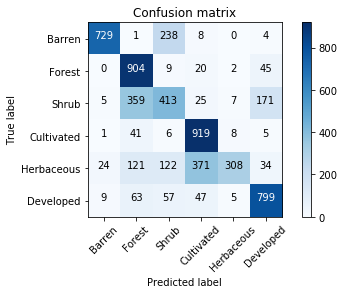

In [16]:
y_pred = eval_predictions['classes']
y_true = eval_labels
cm = confusion_matrix(y_true, y_pred)
luc.plot_confusion_matrix(cm, ["Barren", "Forest", "Shrub", "Cultivated", "Herbaceous", "Developed"])

In [17]:
# Accuracy (all classes)
accuracy = accuracy_score(y_true, y_pred)
print("Accuracy (all classes): ", accuracy)

Accuracy (all classes):  0.692517006803


In [18]:
# Accuracy (Undeveloped, Cultivated, Developed)
y_true = luc.merge_classes(y_true)
y_pred = luc.merge_classes(y_pred)

accuracy = accuracy_score(y_true, y_pred)
print("Accuracy (Undeveloped, Cultivated, Developed): ", accuracy)

Accuracy (Undeveloped, Cultivated, Developed):  0.843537414966


## Load Test Data

In [20]:
if 'train_data' in locals():
    print("Freeing up memory...")
    del train_data
    
if 'eval_data' in locals():
    print("Freeing up memory...")
    del eval_data
    
if 'test_data' in locals():
    print("Freeing up memory...")
    del test_data
    
print("Load testing data")
test_info = luc.gather_image_paths(image_dir, label_to_number_dict, connection_string, mode="test")
test_data, test_labels = luc.load_data(test_info)

print(test_data.shape)
print(test_labels.shape)

Load testing data
Rows Read: 5880, Total Rows Processed: 5880, Total Chunk Time: 25.616 seconds 
\\Tyler-laptop\tylersqlserver\FileTableData\TestData\Shrub\ortho_1-1_hn_s_ca073_2016_1_100283.png
Number of pictures:  5880
(5880, 224, 224, 3)
(5880, 224, 224, 3)
(5880,)


## Score on Test Set
Only run this one time, once the model is tuned to your liking.

In [21]:
# Evaluate the model and print results
test_predictions = classifier.predict(
    x=test_data,
    batch_size=128
)

Tensor("Placeholder:0", shape=(?,), dtype=int64)
INFO:tensorflow:Restoring parameters from \\Tyler-laptop\tylersqlserver\FileTableData\TFTrainCheckpoints\model.ckpt-5000


INFO:tensorflow:Restoring parameters from \\Tyler-laptop\tylersqlserver\FileTableData\TFTrainCheckpoints\model.ckpt-5000


## Analyze Test Results

Confusion matrix, without normalization


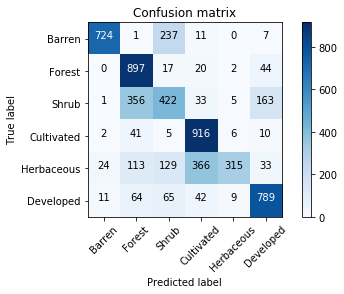

In [22]:
y_pred = test_predictions['classes']
y_true = test_labels
cm = confusion_matrix(y_true, y_pred)
luc.plot_confusion_matrix(cm, ["Barren", "Forest", "Shrub", "Cultivated", "Herbaceous", "Developed"])

In [23]:
# Accuracy (all classes)
accuracy = accuracy_score(y_true, y_pred)
print("Accuracy (all classes): ", accuracy)

Accuracy (all classes):  0.690986394558


In [24]:
# Accuracy (Undeveloped, Cultivated, Developed)
y_true = luc.merge_classes(y_true)
y_pred = luc.merge_classes(y_pred)

accuracy = accuracy_score(y_true, y_pred)
print("Accuracy (Undeveloped, Cultivated, Developed): ", accuracy)

Accuracy (Undeveloped, Cultivated, Developed):  0.841496598639
